# Ramanujan’s τ (Tau) Function

Ramanujan introduced the **τ-function**, denoted \( \tau(n) \), via the Fourier expansion of the modular discriminant \( \Delta(q) \):
$$
\Delta(q) \;=\; q \prod_{n=1}^{\infty} (1 - q^n)^{24}
\;=\; \sum_{n=1}^{\infty} \tau(n)\, q^n .
$$

The coefficients \( \tau(n) \) encode deep arithmetic structure. Ramanujan conjectured (later proved by Deligne) the famous bound for primes:
$$
|\tau(p)| \le 2\,p^{11/2}\quad (p \text{ prime}).
$$

In this notebook we will:
- Compute \( \tau(n) \) for the first \( N \) integers by expanding \( \Delta(q) \) as a truncated \( q \)-series,
- Visualize \( |\tau(n)| \),
- Compare \( |\tau(p)| \) to Deligne’s bound for primes \( p \).


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb


In [7]:
def tau_values(limit=100):
    """
    Compute τ(1),...,τ(limit) from the truncated expansion of
    Δ(q) = q * ∏_{n≥1} (1 - q^n)^{24}.
    Returns a NumPy array of length `limit` with dtype=object (exact ints).
    """
    L = limit  # truncate terms beyond q^L
    coeffs = np.zeros(L + 1, dtype=object)
    coeffs[0] = 1  # start with 1 for the product identity

    # Multiply by (1 - q^n)^{24} for n = 1..L (higher n can't affect <= q^L)
    for n in range(1, L + 1):
        term = np.zeros(L + 1, dtype=object)
        # (1 - q^n)^{24} = sum_{k=0}^{24} (-1)^k * C(24,k) * q^{n k}
        max_k = min(24, L // n)
        for k in range(0, max_k + 1):
            power = n * k
            term[power] = ((-1)**k) * comb(24, k)
        # convolve and truncate to degree L
        coeffs = np.convolve(coeffs, term)[:L + 1].astype(object)

    # Δ(q) = q * (product above), so shift by 1 power of q
    delta = np.zeros(L + 1, dtype=object)
    delta[1:] = coeffs[:-1]  # shift right by 1; drop the highest term

    # τ(1)..τ(L) are coefficients of q^1..q^L
    return delta[1:L+1]

# compute first 100 values
taus = tau_values(100)
taus[:10]


array([1, -24, 252, -1472, 4830, -6048, -16744, 84480, -113643, -115920],
      dtype=object)

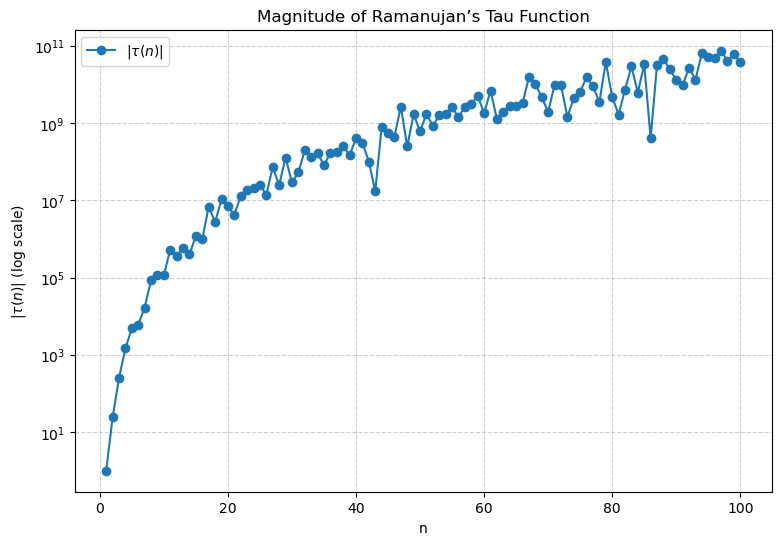

In [8]:
n = np.arange(1, len(taus) + 1)
abs_taus = np.abs(taus.astype(object))

plt.figure(figsize=(9,6))
plt.plot(n, abs_taus, 'o-', label=r'$|\tau(n)|$')
plt.yscale('log')
plt.xlabel('n')
plt.ylabel(r'$|\tau(n)|$ (log scale)')
plt.title("Magnitude of Ramanujan’s Tau Function")
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.show()



In [9]:
from math import gcd

def check_multiplicativity(taus):
    ok = True
    failed = []
    # small sanity checks up to, say, 40
    for a in range(2, min(40, len(taus))):
        for b in range(2, min(40, len(taus))):
            if gcd(a, b) == 1 and a*b <= len(taus):
                lhs = int(taus[a*b - 1])              # τ(ab)
                rhs = int(taus[a - 1]) * int(taus[b - 1])  # τ(a)τ(b)
                if lhs != rhs:
                    ok = False
                    failed.append((a, b, lhs, rhs))
                    if len(failed) >= 5:
                        return ok, failed
    return ok, failed

ok, issues = check_multiplicativity(taus)
ok, issues[:3]


(True, [])

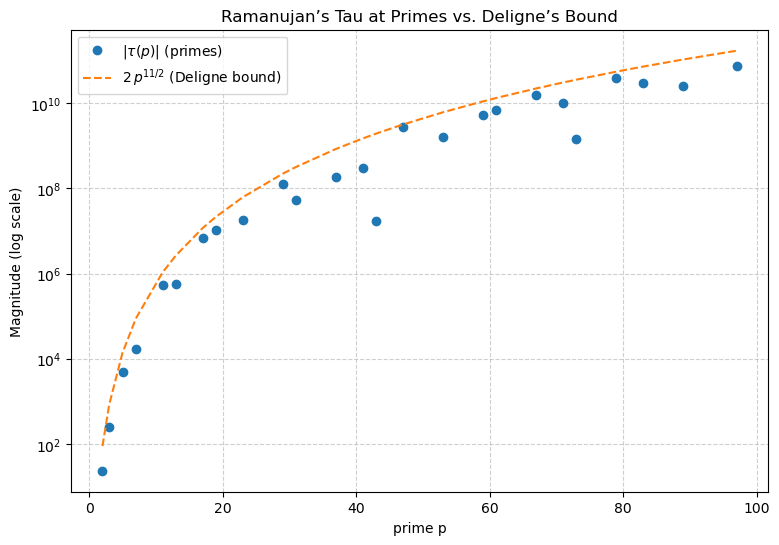

In [10]:
def primes_up_to(n):
    sieve = [True]*(n+1)
    sieve[0:2] = [False, False]
    for p in range(2, int(n**0.5)+1):
        if sieve[p]:
            step = p
            start = p*p
            sieve[start:n+1:step] = [False]*(((n - start)//step) + 1)
    return [i for i, s in enumerate(sieve) if s]

limit = len(taus)
primes = [p for p in primes_up_to(limit) if p >= 2]
tau_primes = np.array([int(taus[p-1]) for p in primes], dtype=float)
bound_primes = np.array([2 * (p**(11/2)) for p in primes], dtype=float)

plt.figure(figsize=(9,6))
plt.plot(primes, np.abs(tau_primes), 'o', label=r'$|\tau(p)|$ (primes)')
plt.plot(primes, bound_primes, '--', label=r'$2\,p^{11/2}$ (Deligne bound)')
plt.yscale('log')
plt.xlabel('prime p')
plt.ylabel(r'Magnitude (log scale)')
plt.title("Ramanujan’s Tau at Primes vs. Deligne’s Bound")
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.show()


### Discussion

- **Definition:**  
  $$\Delta(q) = q\prod_{n\ge1} (1-q^n)^{24} = \sum_{n\ge1}\tau(n)q^n$$  
  gives \( \tau(n) \) as the coefficients of a weight-12 cusp form.

- **Multiplicativity:**  
  For \( \gcd(m,n)=1 \),  
  $$\tau(mn)=\tau(m)\tau(n).$$  
  The quick check above verifies this for small coprime pairs.

- **Prime powers:**  
  $$\tau(p^{r+1})=\tau(p)\tau(p^r)-p^{11}\tau(p^{r-1}).$$

- **Deligne bound:**  
  For primes \( p \),  
  $$|\tau(p)|\le 2p^{11/2}$$  
  (proved using deep results in the theory of modular forms).

- **Growth and oscillation:**  
  \( \tau(n) \) grows quickly in magnitude and changes sign in a structured way tied to modular symmetries.

> **Performance tip:**  
> The q-series expansion scales roughly like \( O(L \cdot 24) \) polynomial steps with truncated convolution.  
> Values up to \( L = 200 \) are reasonable on a modern laptop; increase with care.
